#Sections
0. [Imports and README](#s0)
1. [Initial Data Acquisition](#s1)
  - Oil Site 1 Image
  - Oil Site 2 Image
2. [Data Prep and Pre-processing](#s2) (output are scaled image data and labels to be run through feature engineering)
  - Scaling Image Arrays
  - Generating KMeans Labels
  - Obtaining Hand-Labels
  - Account for Image Class Imbalances
    - **(oversample, undersample, SMOTE)** *PRACHI*
3. [Feature Engineering](#s3) (output are datasets of feature combinations to be run through models) *MARCH*
  - **Adding Spectral Indices (SI)**
  - **Adding Dynamic World Data**
  - **Correlation Matrices [describe impact of bands and spectra]**
4. [Modeling](#s4) (output are model predictions to be evaluated) *IAN*
  - Random Forest Classifer
  - XGBoost
  - Support Vector Machine
  - **Optimization [Create function to execute parameter optimization, feature optimization (trimming, PCA)]**
5. [Results and Discussion](#s5) (output are metric evaluation visualizations)
  - **[Create function to display results]** *MADDIE*
  - **[Light-weight FMEA]** *TBD*
  - **[Discuss KMeans]**
6. [Appendix of Helpful Code Snippets](#s6)


## 0. README, Imports, and Account Authentication <a name="s0"></a>

In [1]:
#import or install necessary packages.
import sys
!{sys.executable} -m pip install earthengine-api rasterio

import ee
import rasterio
from rasterio.plot import show as showRasterio

from google.colab import drive

import zipfile
import os
import requests

import numpy as np
from sklearn import svm
!pip install xgboost
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import imblearn
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

import pandas as pd
from PIL import Image
import cv2, zlib, base64, io
import json

import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Mount your google drive in google colab.
drive.mount('/content/drive', force_remount=True)

# Insert the directory.
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

# Trigger the authentication flow for Google EE.
ee.Authenticate()

# Initialize the EE library.
ee.Initialize()

Mounted at /content/drive
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=vNx-I_hhXFcyCw2BbyLlf0YeA4MeQ-vBVM3X7FLdrKQ&tc=zxXp8etQoVszAwMs8cNoA-zH7KkY_RjrcKAzBRRtY20&cc=3ANftuLfOOjJ1yjn4pk7tcPH-z99NpK5YcoZ2IWM90U

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJq5fhANEDD9svz9l9C2eyoDH6lZCHIEGj9ivJlhMmRycxY6JCWqKrE

Successfully saved authorization token.


## 1. Initial Data Acquisition <a name="s1"></a>

In [3]:
# Code to download images from multiple satellites.
def getSentinalS2_S1Image(lon, lat, sze, filename, dateMin = '2020-04-01', dateMax = '2020-04-30', vmin = 0, vmax = 3500, satellites = ['S2','S1'], 
                          bands=['B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12'], scale=10):
    '''    
    download image from the Sentinal S2 and S1 satellites, at the given coordinates
    
    lon : central longitude in degrees
    lat : central latitude in degrees
    sze : size of the edge of the box in degrees
    dateMin : minimum date to use for image search in year-month-day (e.g., 2020-08-01)
    dateMax : maximum date to use for image search in year-month-day (e.g., 2020-08-31)
    vMin : minimum value to select in the Sentinal image pixels (I think this should be close to 0)
    vMax : maximum value to select in the Sentinal image pixels (I think this should be close to 3000)
    filename : output filename for the GeoTIFF image
    
    Note: it's possible that the vMin and vMax values should be different for each band to make the image look nicer
    
    https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
    https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD
    '''


    print('Sentinel-2 MSI: MultiSpectral Instrument, Level-2A... ')
    
    # define the area of interest, using the Earth Engines geometry object
    coords = [
         [lon - sze/2., lat - sze/2.],
         [lon + sze/2., lat - sze/2.],
         [lon + sze/2., lat + sze/2.],
         [lon - sze/2., lat + sze/2.],
         [lon - sze/2., lat - sze/2.]
    ]
    print(f"Coordinates: ", coords)
    aoi = ee.Geometry.Polygon(coords)
    if 'S2' in satellites:
      # get the image using Google's Earth Engine
      db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR')\
                        .filterBounds(aoi)\
                        .filterDate(ee.Date(dateMin), ee.Date(dateMax))\
                        .sort('CLOUDY_PIXEL_PERCENTAGE')\
                        .first())
      
      # add the latitude and longitude
      db = db.addBands(ee.Image.pixelLonLat())

      # define the S2 bands to download.
      '''
      B1 - 60m pixel size - mentioned in paper, but not used in modeling... 

      B2 - 10m pixel size
      B3 - 10m pixel size
      B4 - 10m pixel size
      B8 - 10m pixel size

      B5 - 20m pixel size (red edge 1)
      B6 - 20m pixel size (red edge 2)
      B7 - 20m pixel size (red edge 3)
      B8A - 20m pixel size (red edge 4)
      B11 - 20m pixel size (SWIR1)
      B12 - 20m pixel size (SWIR2)

      '''
      bands = bands

      # export geotiff images, these go to Drive and then are downloaded locally
      for selection in bands:
          task = ee.batch.Export.image.toDrive(image=db.select(selection),
                                      description=selection,
                                      scale=scale,
                                      region=aoi,
                                      fileNamePrefix=selection,
                                      crs='EPSG:4326',
                                      fileFormat='GeoTIFF')
          task.start()

          url = db.select(selection).getDownloadURL({
              'scale': scale, # ADJUST THIS TO ACTUAL BAND MINIMUM 
              'crs': 'EPSG:4326',
              'fileFormat': 'GeoTIFF',
              'region': aoi})
      
          r = requests.get(url, stream=True)

          filenameZip = selection+'.zip'
          filenameTif = selection+'.tif'

          # unzip and write the tif file, then remove the original zip file
          with open(filenameZip, "wb") as fd:
              for chunk in r.iter_content(chunk_size=1024):
                  fd.write(chunk)

          zipdata = zipfile.ZipFile(filenameZip)
          zipinfos = zipdata.infolist()

          # iterate through each file (there should be only one)
          for zipinfo in zipinfos:
              zipinfo.filename = filenameTif
              zipdata.extract(zipinfo)
      
          zipdata.close()
          
      # create a combined RGB geotiff image, https://gis.stackexchange.com/questions/341809/merging-sentinel-2-rgb-bands-with-rasterio
      print('Creating 3-band GeoTIFF image ... ')
      
      # Define which bands are to be displayed.
      B2 = rasterio.open('B2.tif')
      B3 = rasterio.open('B3.tif')
      B4 = rasterio.open('B4.tif')
      x, y = B4.read(1).shape # this is for final np.array.

      # get the scaling
      image = np.array([B2.read(1), B3.read(1), B4.read(1)]).transpose(1,2,0)
      p2, p98 = np.percentile(image, (2,98))

      # use the B2 image as a starting point so that I keep the same parameters
      B2_geo = B2.profile
      B2_geo.update({'count': 3})

      with rasterio.open(filename, 'w', **B2_geo) as dest:
          dest.write( (np.clip(B4.read(1), p2, p98) - p2)/(p98 - p2)*255, 1)
          dest.write( (np.clip(B3.read(1), p2, p98) - p2)/(p98 - p2)*255, 2)
          dest.write( (np.clip(B2.read(1), p2, p98) - p2)/(p98 - p2)*255, 3)

      B2.close()
      B3.close()
      B4.close()
      
      # update here to output np.array, https://rasterio.readthedocs.io/en/latest/topics/reading.html
      img_spectra = np.zeros((x,y))
      for band in bands:
        img = rasterio.open(band +'.tif')
        img_spectra = np.dstack((img_spectra,np.array(img.read(1))))

      # remove the intermediate files
      for selection in bands:
          os.remove(selection + '.tif')
          os.remove(selection + '.zip')


    if 'S1' in satellites:
      print('Downloading Sentinel-1 SAR GRD: C-band Synthetic Aperture Radar Ground Range Detected, log scaling... ')
      # get the image using Google's Earth Engine
      db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD')\
                        .filterBounds(aoi)\
                        .filterDate(ee.Date(dateMin), ee.Date(dateMax))\
                        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
                        .first())
      
      # add the latitude and longitude
      db = db.addBands(ee.Image.pixelLonLat())

      # See paper, only need these two bands.
      # https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD#bands
      bands_S1 = ['VV','VH']

      # export geotiff images, these go to Drive and then are downloaded locally
      for selection in bands_S1:
          task = ee.batch.Export.image.toDrive(image=db.select(selection),
                                      description=selection,
                                      scale=scale,
                                      region=aoi,
                                      fileNamePrefix=selection,
                                      crs='EPSG:4326',
                                      fileFormat='GeoTIFF')
          task.start()

          url = db.select(selection).getDownloadURL({
              'scale': scale, #ADJUST THIS TO ACTUAL BAND MINIMUM
              'crs': 'EPSG:4326',
              'fileFormat': 'GeoTIFF',
              'region': aoi})
      
          r = requests.get(url, stream=True)

          filenameZip = selection+'.zip'
          filenameTif = selection+'.tif'

          # unzip and write the tif file, then remove the original zip file
          with open(filenameZip, "wb") as fd:
              for chunk in r.iter_content(chunk_size=1024):
                  fd.write(chunk)

          zipdata = zipfile.ZipFile(filenameZip)
          zipinfos = zipdata.infolist()

          # iterate through each file (there should be only one)
          for zipinfo in zipinfos:
              zipinfo.filename = filenameTif
              zipdata.extract(zipinfo)
      
          zipdata.close()

      # Open relevant images.
      VV = rasterio.open('VV.tif')
      VH = rasterio.open('VH.tif')
      x,y = VH.read(1).shape # this is for final np.array.
      
      # create relevant numpy array.
      for band in bands_S1:
        img = rasterio.open(band +'.tif')
        img_spectra = np.dstack((img_spectra,np.array(img.read(1))))
        bands.append(band)

      # remove the intermediate files
      for selection in bands_S1:
          os.remove(selection + '.tif')
          os.remove(selection + '.zip')
      

    return bands, img_spectra[:,:,1:] # remove the first dimension of zeros.

In [4]:
# Sudan oil spill 1.
lat =  9.613842
lon = 29.626897
sze = 0.0167 # following grid from paper

bands, img = getSentinalS2_S1Image(lon, lat, sze, 'Sentinel2-SudanSpill1-09-28-2019.tif', dateMin='2019-09-28', dateMax='2019-09-29', satellites='S2')

np.save('Sentinel2-SudanSpill1-09-28-2019.npy', img)

Sentinel-2 MSI: MultiSpectral Instrument, Level-2A... 
Coordinates:  [[29.618547, 9.605492], [29.635247, 9.605492], [29.635247, 9.622192], [29.618547, 9.622192], [29.618547, 9.605492]]
Creating 3-band GeoTIFF image ... 


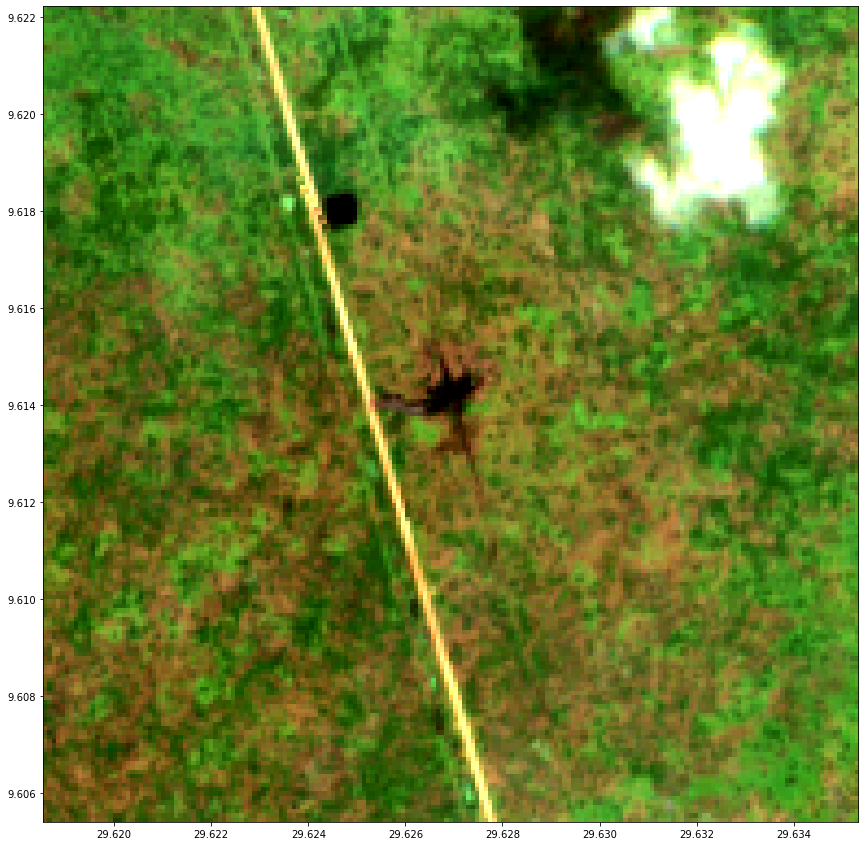

In [5]:
# Display Oil Spill Site 1.

f,ax = plt.subplots(figsize=(15,15))

chicago = rasterio.open('Sentinel2-SudanSpill1-09-28-2019.tif')
showRasterio(chicago.read(), ax = ax, transform=chicago.transform)

f.savefig('SudanSpill1.png', bbox_inches='tight')

chicago.close()

In [6]:
# Sudan oil spill 2.
lat =  9.559211
lon = 29.645236
sze = 0.025

bands_2, img_2 = getSentinalS2_S1Image(lon, lat, sze, 'Sentinel2-SudanSpill2-01-06-2020.tif', dateMin='2020-01-06', dateMax='2020-01-07', satellites='S2')

np.save('Sentinel2-SudanSpill2-01-06-2020.npy', img_2)

Sentinel-2 MSI: MultiSpectral Instrument, Level-2A... 
Coordinates:  [[29.632736, 9.546711], [29.657736, 9.546711], [29.657736, 9.571710999999999], [29.632736, 9.571710999999999], [29.632736, 9.546711]]
Creating 3-band GeoTIFF image ... 


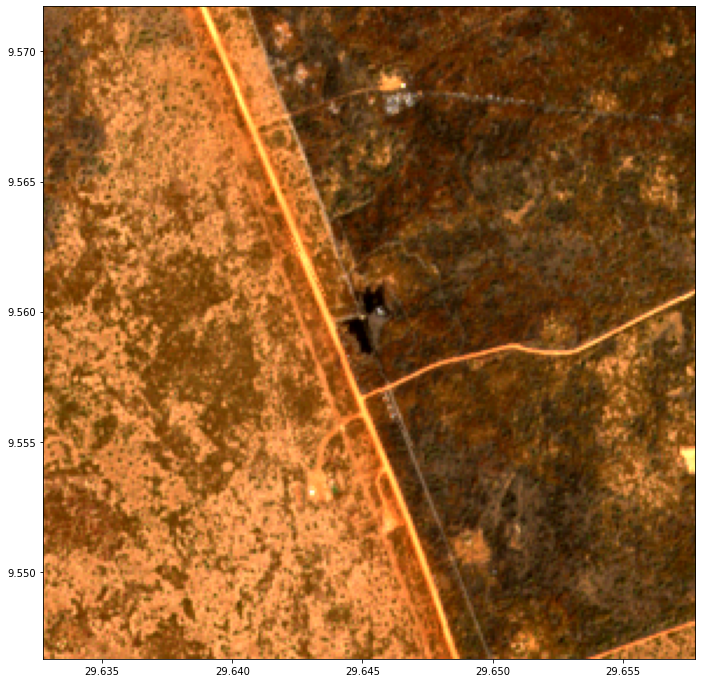

In [7]:
# Display Oil Spill Site 2.

f,ax = plt.subplots(figsize=(12,12))

chicago = rasterio.open('Sentinel2-SudanSpill2-01-06-2020.tif')
showRasterio(chicago.read(), ax = ax, transform=chicago.transform)

f.savefig('SudanSpill2-01-06-2020.png', bbox_inches='tight')

chicago.close()

## 2. Data Preparation and Pre-processing <a name="s2"></a>

### Scale Image Dimensions <a name="s2-scale"></a>

In [8]:
def scale(arr):
  # scales the values of a 2d array between 0 and 1.

  flat = arr.ravel()
  top, bottom = max(flat), min(flat)
    
  scaled = []
  for pix in flat:
    new = (pix-bottom) / (top-bottom)
    scaled.append(new)
    
  scaled_arr = np.array(scaled).reshape(arr.shape)
  return scaled_arr


def display_im(im, title, im_shape, im_size=(12,12), n_legend=6):
  fig = plt.figure(figsize=im_size)
  ax = fig.add_subplot(111)
  ax.set_title(title)
  plt.imshow(im)
  ax.set_aspect('equal')

  n = n_legend # how many lines to draw or number of discrete color levels
  x = np.linspace(0,1,17)
  cmap = plt.get_cmap("viridis", n)
  norm= matplotlib.colors.BoundaryNorm(np.arange(0,n+1)-0.5, n)
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
  sm.set_array([])
  plt.colorbar(sm, ticks=np.arange(0,n),fraction=0.046, pad=0.04)
  plt.show()

In [9]:
# scale dimensions of image
img_scaled = np.zeros(img.shape) # site 1
img_scaled_site2 = np.zeros(img_2.shape) # site 2

for layer in range(img.shape[2]):
  img_scaled[:,:,layer] = scale(img[:,:,layer])

for layer in range(img_2.shape[2]):
  img_scaled_site2[:,:,layer] = scale(img_2[:,:,layer])

# Reshape image array for clustering.
kmeans_input = img_scaled.reshape(187*187,11)
kmeans_input_site2 = img_scaled_site2.reshape(279*279,11)

### Generate KMeans Labels <a name="s2-KMeansLabels"></a>

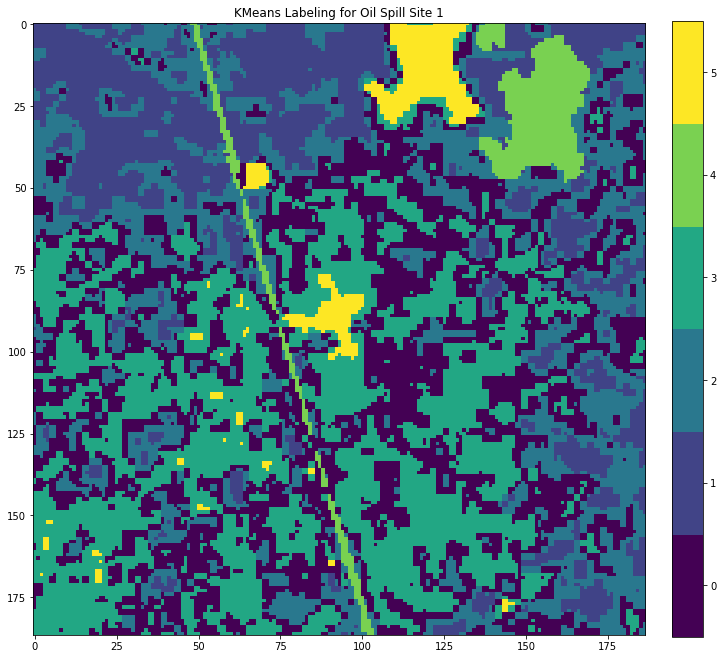

In [10]:
# Try KMeans Clustering with scaling.
Kmean = KMeans(n_clusters=6, random_state=30)
Kmean.fit(kmeans_input)


# Reshape model labels for displaying output.
Kmean.labels_.shape
kmeans_labels = Kmean.labels_.reshape(187,187)


# Display labels
display_im(kmeans_labels, "KMeans Labeling for Oil Spill Site 1", (187,187))

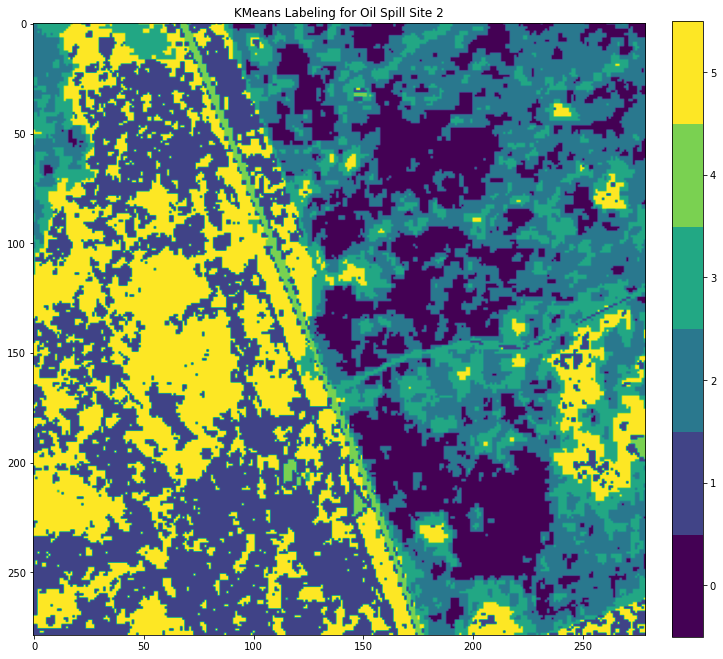

In [11]:
# Try KMeans Clustering with scaling.
n=6

Kmean_site2 = KMeans(n_clusters=n, random_state=30)
#Kmean = KMeans(n_clusters=6, random_state=30, n_init=100, max_iter=500, tol=1e-7, algorithm='auto')
Kmean_site2.fit(kmeans_input_site2)


# Reshape model labels for displaying output.
Kmean_site2.labels_.shape
kmeans_labels_site2 = Kmean_site2.labels_.reshape(279,279)

# Display labels
display_im(kmeans_labels_site2, "KMeans Labeling for Oil Spill Site 2", (279,279))

### Obtain Hand-Labeled Data <a name="s2-HandLabels"></a>
Pseudo-code: Create hand-labeled data (from March's ipynb)
- obtain manually-generated labeled image labels

In [12]:
def scale_for_png(sentinel_arr):
  red = sentinel_arr[:,:,2]/np.amax(sentinel_arr[:,:,2])*255
  green = sentinel_arr[:,:,1]/np.amax(sentinel_arr[:,:,1])*255
  blue = sentinel_arr[:,:,0]/np.amax(sentinel_arr[:,:,0])*255
  
  im = np.dstack([red, green, blue])

  im = Image.fromarray(im.astype(np.uint8))

  return im


def base64_2_mask(s):
  z = zlib.decompress(base64.b64decode(s))
  n = np.fromstring(z, np.uint8)
  mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
  return mask


def create_bitmask_multi(img, pixels, origin, label):
  mask = img

  x0 = origin[0]
  x1 = origin[0] + pixels.shape[1] # are pixels dimensions (y,x)? YES.

  y0 = origin[1]
  y1 = origin[1] + pixels.shape[0]

  mask[y0:y1, x0:x1] = np.where(pixels == True, label, mask[y0:y1, x0:x1])

  
  return mask

In [13]:
s1a = np.load("/content/drive/MyDrive/Colab Notebooks/Sentinel2-SudanSpill1-09-28-2019.npy")
s2a = np.load("/content/drive/MyDrive/Colab Notebooks/Sentinel2-SudanSpill2-01-06-2020.npy")

In [14]:
# Create png and download. Necessary if creating hand-labeled image for first time.
#im = scale_for_png(s1a)
#im.save("SudanSpill1.jpeg")
#im

In [15]:
# obtain image hand-labels for multi-class annotation
with open("/content/drive/MyDrive/Colab Notebooks/SudanSpill1-multi.json", "r") as f:
  labels = json.load(f)
#labels

n = len(labels['objects'])
s1a_oil_multi = np.full((s1a.shape[0],s1a.shape[1]),n)

for layer in range(len(labels['objects'])):
  pixels = labels['objects'][layer]['bitmap']['data']
  origin = labels['objects'][layer]['bitmap']['origin']
  pixels = base64_2_mask(pixels)

  s1a_oil_multi = create_bitmask_multi(s1a_oil_multi, pixels, origin, layer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  from ipykernel import kernelapp as app


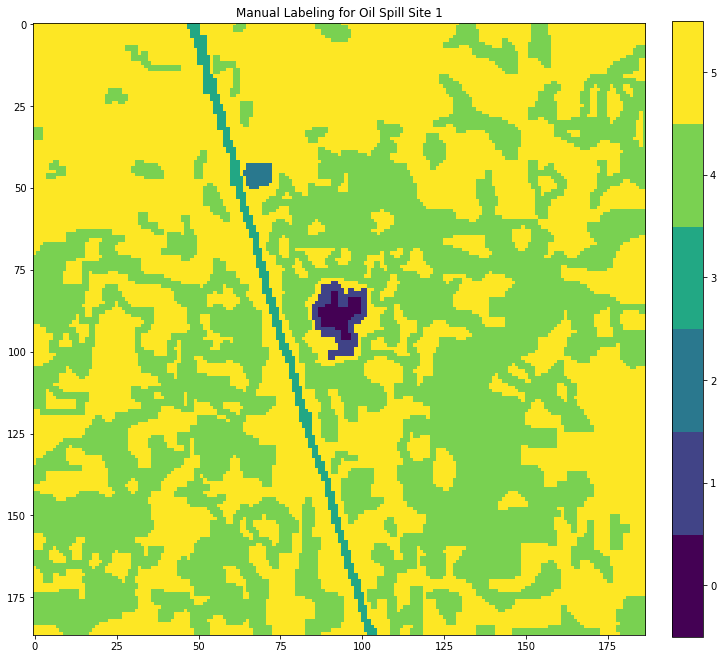

In [16]:
# Explore hand-labels and convert to int.
hand_labels = s1a_oil_multi.astype(int) # convert to int
display_im(hand_labels.reshape(187,187), "Manual Labeling for Oil Spill Site 1", (187,187))

In [17]:
# obtain image hand-labels for multi-class annotation

s2a = np.load("/content/drive/MyDrive/Colab Notebooks/Sentinel2-SudanSpill2-01-06-2020.npy")
with open("/content/drive/MyDrive/Colab Notebooks/SudanSpill2-multi.json", "r") as f:
  labels = json.load(f)

n = len(labels['objects'])
s2a_oil_multi = np.full((s2a.shape[0],s2a.shape[1]),n)

for layer in range(len(labels['objects'])):
  pixels = labels['objects'][layer]['bitmap']['data']
  origin = labels['objects'][layer]['bitmap']['origin']
  pixels = base64_2_mask(pixels)

  s2a_oil_multi = create_bitmask_multi(s2a_oil_multi, pixels, origin, layer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  from ipykernel import kernelapp as app


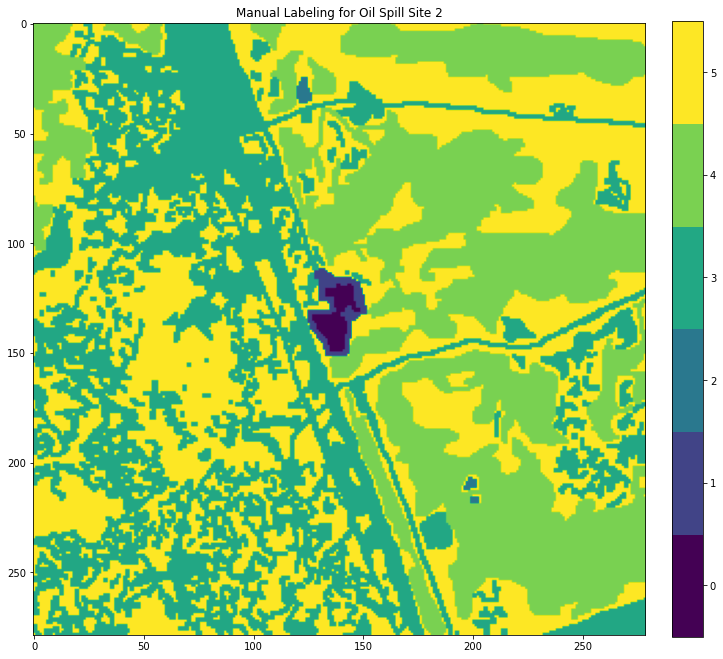

In [18]:
# Explore hand-labels and convert to int.
hand_labels_2 = s2a_oil_multi.astype(int) # convert to int
display_im(hand_labels_2.reshape(279,279), "Manual Labeling for Oil Spill Site 2", (279,279))

### Account for Image Class Imbalances <a name="s2-imbalance"></a>

Psuedo-code:
- try using techniques from: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

In [19]:
# Image and label datasets
img_flat = kmeans_input
img_2_flat = kmeans_input_site2
hand_labels_flat = hand_labels.ravel().reshape(-1,1)
hand_labels_2_flat = hand_labels_2.ravel().reshape(-1,1)

In [20]:
rus = RandomUnderSampler(random_state=42, replacement=True)

# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(kmeans_input, hand_labels.ravel().reshape(-1,1))

In [21]:
#ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
#x_ros, y_ros = ros.fit_resample(x, y)

In [22]:
#tl = RandomOverSampler(sampling_strategy='majority')

# fit predictor and target variable
#x_tl, y_tl = ros.fit_resample(x, y)

In [23]:
#smote = SMOTE()

# fit predictor and target variable
#x_smote, y_smote = smote.fit_resample(x, y)

In [24]:
#tl = TomekLinks(sampling_strategy='majority')

# fit predictor and target variable
#x_tl, y_tl = ros.fit_resample(x, y)

Section 2 Output:

## 3. Feature Engineering  <a name="s3"></a>

These need to be added from March's ipynb...

### Add Spectral Indices

### Add Dynamic World Data

Section 3 Output:

## 4. Modeling  <a name="s4"></a>

Pseudo-code: Train models with various training sets
- train Random Forest model with multi-class training data
- train XGBoost model with multi-class training data
- train SVM model with multi-class training data

### Create image data sets, and labels

In [25]:
# Train/test split with set random seed.
test_size = 0.5
random_state = 10

X_train, X_test, y_train, y_test = train_test_split(img_flat, hand_labels_flat, test_size=test_size, random_state=random_state)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(img_2_flat, hand_labels_2_flat, test_size=test_size, random_state=random_state)

### Random Forest Classifier

In [26]:
# Train and test Random Forest Classifier.
RFClassifier_2 = RandomForestClassifier(n_estimators=20, random_state=0)
RFClassifier_2.fit(X_train_2, y_train_2)
y_pred_2 = RFClassifier_2.predict(X_test_2)


# Evalute results on multi-class test set.
#print("\n\nMULTI-CLASS TEST SET:\n")
#print("\nconfusion matrix:\n",confusion_matrix(y_test_2,y_pred_2))
#print("\nclassification report:\n",classification_report(y_test_2,y_pred_2))
#print("\naccuracy score:\n",accuracy_score(y_test_2, y_pred_2),"\n\n\n")

# code for visualization of confusion matrices
#plot_confusion_matrix(RFClassifier_2, X_test_2, y_test_2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
# Predict labels
labels_rf_2 = RFClassifier_2.predict(img_2_flat)

# Display labels
#display_im(labels_rf_2.reshape(279,279), "Random Forest Predictions for Oil Spill Site 2", (279,279))

In [28]:
# Repeat with XGBoost
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,y_train)
y_pred_xgb = xgb_classifier.predict(X_test)


# Evalute.
#print("confusion matrix:\n",confusion_matrix(y_test,y_pred_xgb))
#print("classification report:\n",classification_report(y_test,y_pred_xgb))
#print("accuracy score:\n",accuracy_score(y_test, y_pred_xgb))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
# Repeat with SVM.
#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # 0.9736917357735202
#clf = svm.SVC(kernel='linear') # 0.8989133543036889
#clf = svm.SVC(kernel='poly') # 0.9275092936802974
#clf = svm.SVC(kernel='sigmoid') # 0.4376608521589934
#clf = svm.SVC(kernel='precomputed') # error, because matrix must be square...

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_svm = clf.predict(X_test)

# Evalute.
#print("confusion matrix:\n",confusion_matrix(y_test,y_pred_svm))
#print("classification report:\n",classification_report(y_test,y_pred_svm))
#print("accuracy score:\n",accuracy_score(y_test, y_pred_svm))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Optimize model parameters
Pseudo-code: optimize model training parameters.
- use functions like paramsearch or gridsearch to optimize the model training based on multi-class labels.

## 5. Results and Discussion  <a name="s5"></a>



MULTI-CLASS TEST SET:


confusion matrix:
 [[  101     9     0     6    32    12]
 [   14    40     0    29    55    44]
 [    0     0    19     0    22     8]
 [    3     0     0 10487   300  1755]
 [    2     1     0   134  9927  1139]
 [    1     5     2  2373  2447  9954]]

classification report:
               precision    recall  f1-score   support

           0       0.83      0.63      0.72       160
           1       0.73      0.22      0.34       182
           2       0.90      0.39      0.54        49
           3       0.80      0.84      0.82     12545
           4       0.78      0.89      0.83     11203
           5       0.77      0.67      0.72     14782

    accuracy                           0.78     38921
   macro avg       0.80      0.61      0.66     38921
weighted avg       0.78      0.78      0.78     38921


accuracy score:
 0.784358058631587 





/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


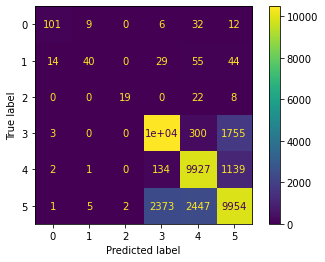

In [33]:
#Template code below. Final data not yet created, but should be able to play around with current set like below.

# Evalute results on multi-class test set.
print("\n\nMULTI-CLASS TEST SET:\n")
print("\nconfusion matrix:\n",confusion_matrix(y_test_2,y_pred_2))
print("\nclassification report:\n",classification_report(y_test_2,y_pred_2))
print("\naccuracy score:\n",accuracy_score(y_test_2, y_pred_2),"\n\n\n")

# code for visualization of confusion matrices
plot_confusion_matrix(RFClassifier_2, X_test_2, y_test_2)

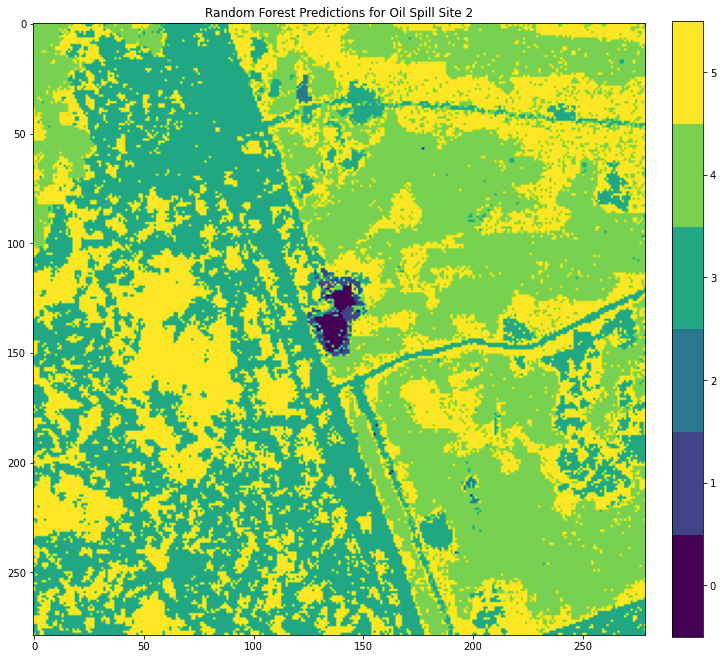

In [34]:
display_im(labels_rf_2.reshape(279,279), "Random Forest Predictions for Oil Spill Site 2", (279,279))

## 6. Appendix of Helpful/Extra Code Snippets  <a name="s6"></a>

Psuedo-code: perform analysis on different cluster types.

1. find averages
2. plot radar charts

In [30]:
### EDA for cluster characteristics.
#labels_flat = labels.ravel().reshape(-1,1)
##img_flat = kmeans_input

#labels_flat.shape # (34969, 1) # DELETE LATER
#img_flat.shape # (34969, 11) # DELETE LATER

In [31]:
### Get distribution of particular label.

#labels_0_all = np.where(labels_flat == 0)[0]
#labels_0_all[0].shape #(9989,) # DELETE LATER
#print(labels_0_all[0:10]) # DELETE LATER

#analysis = np.zeros((labels_0_all.shape[0],img_flat.shape[1]))
#print(analysis.shape)#(9989, 11) # DELETE LATER

#counter = 0
#for idx in labels_0_all:
#  analysis[counter,:] = img_flat[idx,:]
#  counter += 1

# Take mean along dimensions
#means = np.mean(analysis,axis=0)

#plt.hist(means)

In [32]:
### AR for someone...chart some radar charts!

#https://www.geeksforgeeks.org/star-charts-in-python/
#https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html